In [ ]:
!pip install -q livelossplot optuna

import os
import zipfile
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import optuna
from optuna.samplers import TPESampler

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.regularizers import l2
from keras import models, layers
from keras.utils import to_categorical
from keras.initializers import glorot_normal, he_normal
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, ELU, PReLU, LeakyReLU
from keras.optimizers import Adam, RMSprop, Ftrl, Lion
from keras.callbacks import EarlyStopping
from keras.models import load_model
from livelossplot import PlotLossesKeras

le = LabelEncoder()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def process_images(filepath):
    """
    Processes a single file, handling both images and ZIP archives.

    Args:
        filepath (str): The path to the file.

    Returns:
        list: A list of processed images (if applicable), empty otherwise.
    """

    processed_images = []
    processed_labels = []
    if zipfile.is_zipfile(filepath):
        with zipfile.ZipFile(filepath, 'r') as z:
            for file in z.namelist():
                if file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
                    with z.open(file) as img_file:
                        image = plt.imread(img_file)
                        image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_CUBIC)

                        if filepath == '/content/drive/MyDrive/fotos/arrugados.zip':
                           image = image[50:135, 110:175]
                        elif filepath == '/content/drive/MyDrive/fotos/broca.zip':
                          image = image[50:140, 110:170]
                        elif filepath == '/content/drive/MyDrive/fotos/buenos.zip':
                          image = image[70:160, 80:140]
                        elif filepath == '/content/drive/MyDrive/fotos/decolorado.zip':
                          image = image[35:130, 110:160]
                        elif filepath == '/content/drive/MyDrive/fotos/inmaduro.zip':
                          image = image[80:180, 80:150]
                        elif filepath == '/content/drive/MyDrive/fotos/mordido.zip':
                          image = image[45:140, 120:190]
                        elif filepath == '/content/drive/MyDrive/fotos/negro.zip':
                          image = image[60:150, 80:130]
                        elif filepath == '/content/drive/MyDrive/fotos/vinagre.zip':
                          image = image[50:140, 100:170]

                        image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
                        processed_images.append(image)
                        processed_labels.append(os.path.splitext(os.path.basename(filepath))[0])
    elif os.path.isfile(filepath):
        if filepath.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp', '.tiff')):
            try:
                image = plt.imread(filepath)
                image = cv2.resize(image, (250, 250), interpolation = cv2.INTER_CUBIC)

                if filepath == '/content/drive/MyDrive/fotos/arrugados.zip':
                    image = image[50:135, 110:175]
                elif filepath == '/content/drive/MyDrive/fotos/broca.zip':
                  image = image[50:140, 110:170]
                elif filepath == '/content/drive/MyDrive/fotos/buenos.zip':
                  image = image[70:160, 80:140]
                elif filepath == '/content/drive/MyDrive/fotos/decolorado.zip':
                  image = image[35:130, 110:160]
                elif filepath == '/content/drive/MyDrive/fotos/inmaduro.zip':
                  image = image[80:180, 80:150]
                elif filepath == '/content/drive/MyDrive/fotos/mordido.zip':
                  image = image[45:140, 120:190]
                elif filepath == '/content/drive/MyDrive/fotos/negro.zip':
                  image = image[60:150, 80:130]
                elif filepath == '/content/drive/MyDrive/fotos/vinagre.zip':
                  image = image[50:140, 100:170]

                image = cv2.resize(image, (224, 224), interpolation = cv2.INTER_CUBIC)
                processed_images.append(image)
                processed_labels.append(os.path.splitext(os.path.basename(filepath))[0])
            except (OSError, IOError):  # Handle potential image opening errors gracefully
                print(f"Error opening image: {filepath}")

    processed_images = processed_images[:64]
    processed_labels = processed_labels[:64]

    return processed_images, processed_labels

def count_images(imgpath):
    """
    Counts images in a directory and its subdirectories.

    Args:
        imgpath (str): The base directory path.

    Returns:
        tuple: A tuple containing (list of directories, list of image counts per directory, total image count).
    """

    directories = []
    total_count = 0
    current_count = []
    images = []
    labels = []

    for root, _, filenames in os.walk(imgpath):
        # print('leyendo imagenes de ', root)
        for filename in filenames:
            # print('leyendo imagenes de ', os.path.join(root, filename))
            processed_images, processed_labels = process_images(os.path.join(root, filename))

            images.extend(processed_images)
            labels.extend(processed_labels)
            directories.append(os.path.join(root, filename))

            current_count.append(len(processed_images))
            total_count = sum(current_count)

    return directories, current_count, total_count, images, labels

In [ ]:
def visualize_graphs(test_X, test_Y, predicted_classes, figsize=(20, 40), nrows=11, ncols=5):
  """
  Visualizes multiple graphs in a grid layout, coloring nodes based on labels.

  Args:
      test_X: The input data for the test set.
      test_Y: The true class labels for the test set.
      predicted_classes: The predicted class labels for the test set.
      figsize (tuple, optional): Size of the figure. Defaults to (20, 14).
      nrows (int, optional): Number of rows in the grid layout. Defaults to 7.
      ncols (int, optional): Number of columns in the grid layout. Defaults to 9.

  Returns:
      None
  """

  fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
  axs = axs.flatten()

  for i, e in enumerate(test_Y):
      axs[i].imshow(test_X[e], cmap = 'gray')

      if labels is not None:
        axs[i].set_title(f"Original: {le.inverse_transform(test_Y)[i]} \n Predicción {le.inverse_transform(predicted_classes)[i]}", fontsize=20)

      axs[i].axis("off")

  # Turn off graphics over 62
  for j in range(len(predicted_classes), len(axs)):
      axs[j].axis("off")


  plt.tight_layout()
  plt.show()

In [ ]:
# imgpath = 'fotos'  # Replace with your actual directory path
imgpath = '/content/drive/MyDrive/fotos'
directories, current_count, total_count, images, labels = count_images(imgpath)

print('Directorios leídos:', len(directories))
print('Imágenes en cada directorio:', current_count)
print('Suma total de imágenes en subdirectorios:', total_count)
print('Número de etiquetas:', len(labels))

Directorios leídos: 8
Imágenes en cada directorio: [64, 64, 64, 64, 64, 64, 64, 64]
Suma total de imágenes en subdirectorios: 512
Número de etiquetas: 512


La imagen corresponde a la categoria: Arrugados


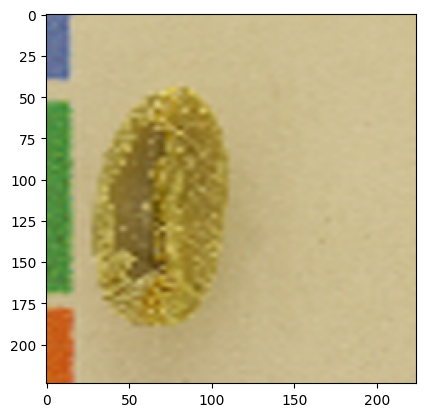

In [ ]:
imagen_ver = images[60]
etiqueta_ver = labels[60]
print(f'La imagen corresponde a la categoria: {etiqueta_ver.capitalize()}')
plt.imshow(imagen_ver)
plt.show()

In [ ]:
# for i in range(0,512):
#   imagen_ver = images[i]
#   etiqueta_ver = labels[i]
#   ###### en Y y X
#   # imagen_ver = imagen_ver[20:200, 90:160]
#   print(etiqueta_ver)
#   plt.imshow(imagen_ver)
#   plt.show()

In [ ]:
y = le.fit_transform(labels)

# convertir array las images y labels
y = np.array(y)
X = np.array(images)

classes = np.unique(y)
nClasses = len(classes)

print('Clases originales: ', le.classes_)
print('Total de numero de salidas: ', nClasses)
print('Output classes: ', classes)

Clases originales:  ['arrugados' 'broca' 'buenos' 'decolorado' 'inmaduro' 'mordido' 'negro'
 'vinagre']
Total de numero de salidas:  8
Output classes:  [0 1 2 3 4 5 6 7]


## Modelo Base

In [ ]:
# train and test, todas las imagenes tienen la misma dimension
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size = 0.1)
print('Training data shape: ', train_X.shape, train_Y.shape)
print('Test data shape: ', test_X.shape, test_Y.shape)

Training data shape:  (460, 224, 224, 3) (460,)
Test data shape:  (52, 224, 224, 3) (52,)


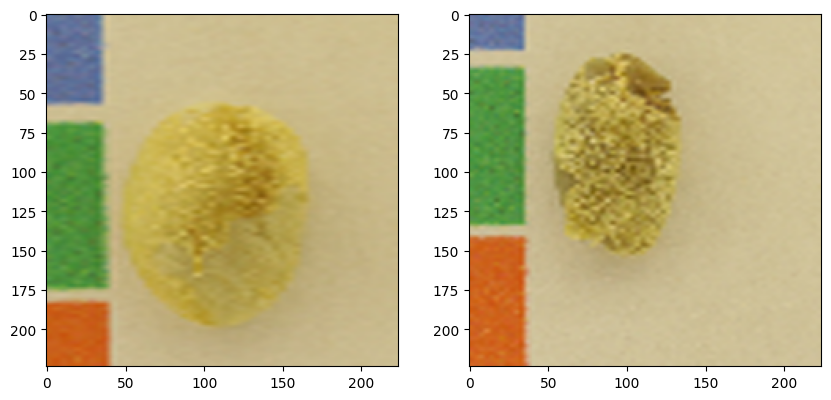

In [ ]:
plt.figure(figsize = [10, 8])

# primera imagen de training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap = 'gray')

# primera imagen de training data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap = 'gray')

In [ ]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

train_X = train_X / 255.
test_X = test_X / 255.

# cambio a categorico
train_Y_one_hot = to_categorical(train_Y)
test_y_one_hot = to_categorical(test_Y)

In [ ]:
train_X, valid_X, train_label, valid_label = train_test_split(train_X, train_Y_one_hot, test_size = 0.2, random_state = 42)
print(train_X.shape, valid_X.shape, train_label.shape, valid_label.shape)

(368, 224, 224, 3) (92, 224, 224, 3) (368, 8) (92, 8)


In [ ]:
# taza de aprendizaje
INIT_LR = 0.001
# iteraciones por conjnto de entrenamiento
epochs = 30
# cantidad de imagenes que se toman a la vez en memoria
batch_size = 64

# input_shape = (250, 250, 3)
input_shape = (224, 224, 3)

## Usando optimizador

In [ ]:
def objective(trial):

    """
    Function to optimize hyperparameter searching with Optuna for a Neural Network.

    Args:
        trial (optuna.Trial): The Optuna trial object for hyperparameter search.

    Returns:
        float: The binary accuracy score of the trained model.
    """

    # Define the search space
    num_filters = trial.suggest_categorical("num_filters", [128, 64, 32])
    num_filters2 = trial.suggest_categorical("num_filters2", [64, 32, 16])
    lLRU = trial.suggest_categorical("lLRU", [0, 0.05, 0.1])
    # dropout = trial.suggest_categorical("dropout", [0, 0.2, 0.3, 0.4, 0.5])

    units1 = trial.suggest_int('units1', 16, 64)
    units2 = trial.suggest_int('units2', 8, 32)
    units3 = trial.suggest_int('units2', 8, 32)
    activation1 = trial.suggest_categorical('activation1', ['relu', 'relu', 'tanh', 'sigmoid'])
    activation2 = trial.suggest_categorical('activation2', ['relu', 'relu', 'tanh', 'sigmoid'])
    dropout2 = trial.suggest_categorical("dropout2", [0, 0.2, 0.3, 0.4, 0.5])

    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'Ftrl', 'Lion'])
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-1)
    optimizers = {
        "Adam": Adam(learning_rate=lr),
        "RMSprop": RMSprop(learning_rate=lr),
        "Ftrl": Ftrl(learning_rate=lr),
        "Lion": Lion(learning_rate=lr),
    }
    optimizer = optimizers[optimizer_name]
    epochs = trial.suggest_int('epochs', 30, 100)

    ### Define the model
    model3 = Sequential()
    model3.add(Conv2D(num_filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape, kernel_initializer=he_normal()))
    model3.add(LeakyReLU(alpha=0.1))
    model3.add(MaxPooling2D((2, 2), padding='same'))
    # model3.add(Dropout(dropout))
    model3.add(Conv2D(num_filters2, kernel_size=(3, 3), activation='relu', padding='same'))
    model3.add(MaxPooling2D((2, 2),padding='same'))
    model3.add(Conv2D(num_filters2, kernel_size=(3, 3), activation='relu', padding='same'))
    model3.add(MaxPooling2D((2, 2),padding='same'))

    model3.add(Flatten())

    model3.add(Dense(units1, activation=activation1))
    model3.add(LeakyReLU(alpha=lLRU))
    # model3.add(Dropout(dropout2))
    model3.add(Dense(units2, activation=activation2))
    model3.add(Dense(units3, activation=activation2))
    model3.add(Dense(nClasses, activation='softmax'))

    ### Compile model
    model3.compile(loss='categorical_crossentropy',
                   optimizer = optimizer,
                   metrics = ['auc'])

    ### Fit model
    model3.fit(train_X, train_label,
               batch_size = batch_size,
               epochs = epochs,
               verbose = 1,
               validation_data = (valid_X, valid_label),
               callbacks=[PlotLossesKeras()])

    ### Evaluate model
    _, val_auc = model3.evaluate(test_X, test_y_one_hot, verbose = 1)

    if val_auc >= 0.75:
        trial_number = trial.number
        model_path = f"model_op_{trial_number}.h5"
        model3.save(model_path)

    return val_auc

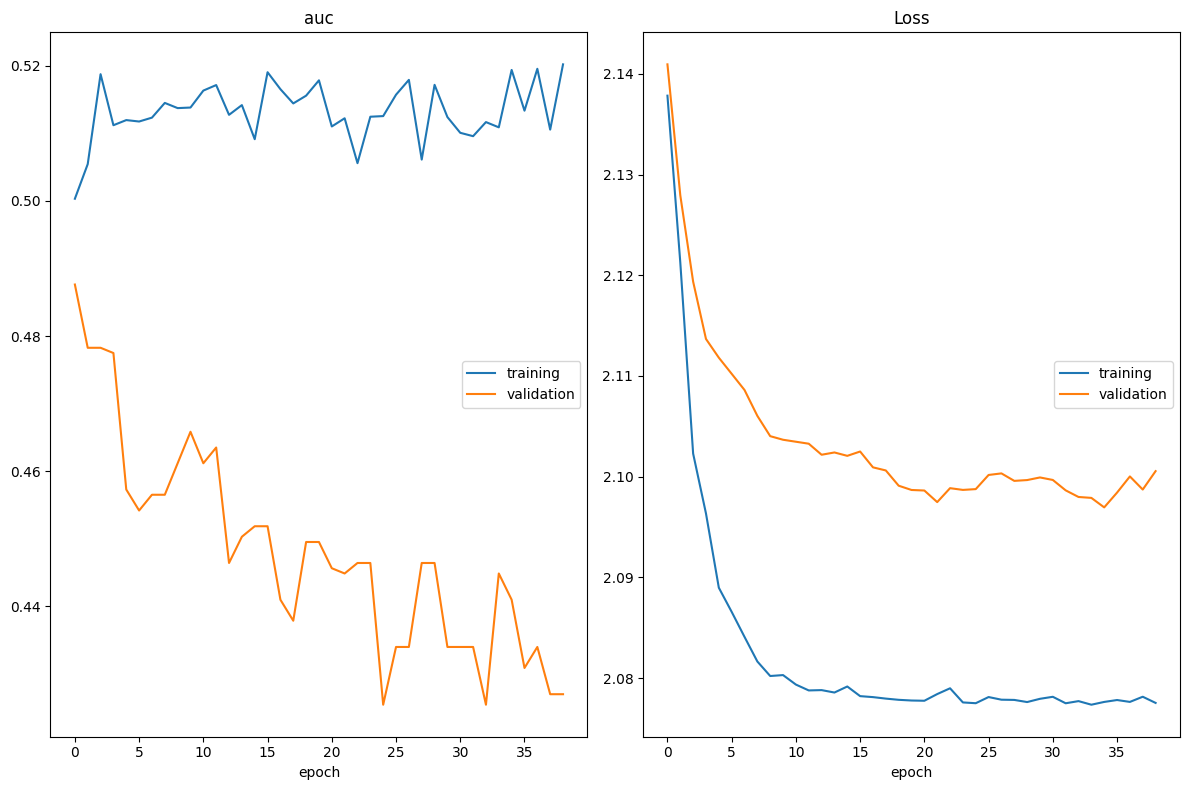

auc
	training         	 (min:    0.500, max:    0.520, cur:    0.520)
	validation       	 (min:    0.425, max:    0.488, cur:    0.427)
Loss
	training         	 (min:    2.077, max:    2.138, cur:    2.078)
	validation       	 (min:    2.097, max:    2.141, cur:    2.101)
6/6 ━━━━━━━━━━━━━━━━━━━━ 55s 9s/step - auc: 0.5318 - loss: 2.0736 - val_auc: 0.4270 - val_loss: 2.1005
Epoch 40/67


[W 2024-12-24 01:33:52,636] Trial 7 failed with parameters: {'num_filters': 64, 'num_filters2': 32, 'lLRU': 0.1, 'units1': 61, 'units2': 23, 'activation1': 'tanh', 'activation2': 'relu', 'dropout2': 0.4, 'optimizer': 'Adam', 'lr': 0.000621318968816377, 'epochs': 67} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-13-4742ee7fddb0>", line 63, in objective
    model3.fit(train_X, train_label,
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 319, in fit
    callbacks.on_train_batch_begin(step)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py", line 98, in on_train_batch_begin

KeyboardInterrupt: 

In [ ]:
study_name = "model_cafe"
storage_name = "sqlite:///{}.db".format(study_name)

study = optuna.create_study(study_name=study_name,
                            direction="maximize",
                            storage=storage_name,
                            pruner=optuna.pruners.HyperbandPruner(max_resource="auto"),
                            sampler=TPESampler())
study.optimize(objective, n_trials = 10)

In [ ]:
df_study = study.trials_dataframe()
df_study.to_csv('df_study.csv', encoding = 'utf-8-sig', index = False)
df_study = df_study.sort_values(by=['value'], ascending=False)
df_study.head()

number     value             datetime_start          datetime_complete  \
4       4  0.932639 2024-12-23 21:11:16.219641 2024-12-23 22:46:43.653462   
5       5  0.872649 2024-12-23 22:46:43.692923 2024-12-23 23:15:45.333334   
3       3  0.564059 2024-12-23 20:24:26.752640 2024-12-23 21:11:16.154656   
0       0  0.510989 2024-12-23 18:23:36.025452 2024-12-23 19:18:17.903020   
6       6  0.478022 2024-12-23 23:15:45.380252 2024-12-24 00:46:57.910699   

                duration params_activation1 params_activation2  \
4 0 days 01:35:27.433821               relu               relu   
5 0 days 00:29:01.640411            sigmoid               relu   
3 0 days 00:46:49.402016            sigmoid            sigmoid   
0 0 days 00:54:41.877568               relu               tanh   
6 0 days 01:31:12.530447               relu               tanh   

   params_dropout2  params_epochs  params_lLRU  params_lr  params_num_filters  \
4              0.2             78         0.00   0.000127                  64   
5              0.2             44         0.00   0.000221                  32   
3              0.5             35         0.05   0.000140                  64   
0              0.5             85         0.05   0.004103                  32   
6              0.2             77         0.00   0.079103                  32   

   params_num_filters2 params_optimizer  params_units1  params_units2  \
4                   32             Lion             32             32   
5                   32          RMSprop             62             11   
3                   64             Adam             17             30   
0                   32             Lion             30             23   
6                   64          RMSprop             36             14   

      state  
4  COMPLETE  
5  COMPLETE  
3  COMPLETE  
0  COMPLETE  
6  COMPLETE

In [ ]:
df_study.shape

(8, 17)

In [ ]:
best_trial = study.best_trial
print("Best value:", best_trial.value)
print("Best parameters:", best_trial.params)

Best value: 0.932639479637146
Best parameters: {'num_filters': 64, 'num_filters2': 32, 'lLRU': 0, 'units1': 32, 'units2': 32, 'activation1': 'relu', 'activation2': 'relu', 'dropout2': 0.2, 'optimizer': 'Lion', 'lr': 0.00012713813462678701, 'epochs': 78}


In [ ]:
hiper = study.best_params
hiper

{'num_filters': 64,
 'num_filters2': 32,
 'lLRU': 0,
 'units1': 32,
 'units2': 32,
 'activation1': 'relu',
 'activation2': 'relu',
 'dropout2': 0.2,
 'optimizer': 'Lion',
 'lr': 0.00012713813462678701,
 'epochs': 78}

In [ ]:
# taza de aprendizaje
INIT_LR = hiper['lr']
# iteraciones por conjnto de entrenamiento
epochs = hiper['epochs']
# cantidad de imagenes que se toman a la vez en memoria
batch_size = 64

input_shape = (224, 224, 3)

In [ ]:
model_op = Sequential()
model_op.add(Conv2D(hiper['num_filters'], kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model_op.add(LeakyReLU(alpha=0.1))
model_op.add(MaxPooling2D((2, 2),padding='same'))
model_op.add(Conv2D(hiper['num_filters2'], kernel_size=(3, 3), activation='relu', padding='same'))
model_op.add(MaxPooling2D((2, 2),padding='same'))

model_op.add(Flatten())

model_op.add(Dense(hiper['units1'], activation=hiper['activation1']))
model_op.add(LeakyReLU(alpha=hiper['lLRU']))
model_op.add(Dense(hiper['units2'], activation=hiper['activation2']))
model_op.add(Dense(nClasses, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [ ]:
model_op.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_31 (Conv2D)                   │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_23 (LeakyReLU)           │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_32 (Conv2D)                   │ (None, 112, 112, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_11 (Flatten)                 │ (None, 100352)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 32)                  │       3,211,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_24 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,232,872 (12.33 MB)

 Trainable params: 3,232,872 (12.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_op.compile(loss='categorical_crossentropy',
                 optimizer = tf.optimizers.Lion(INIT_LR),
                 metrics = ['auc'])

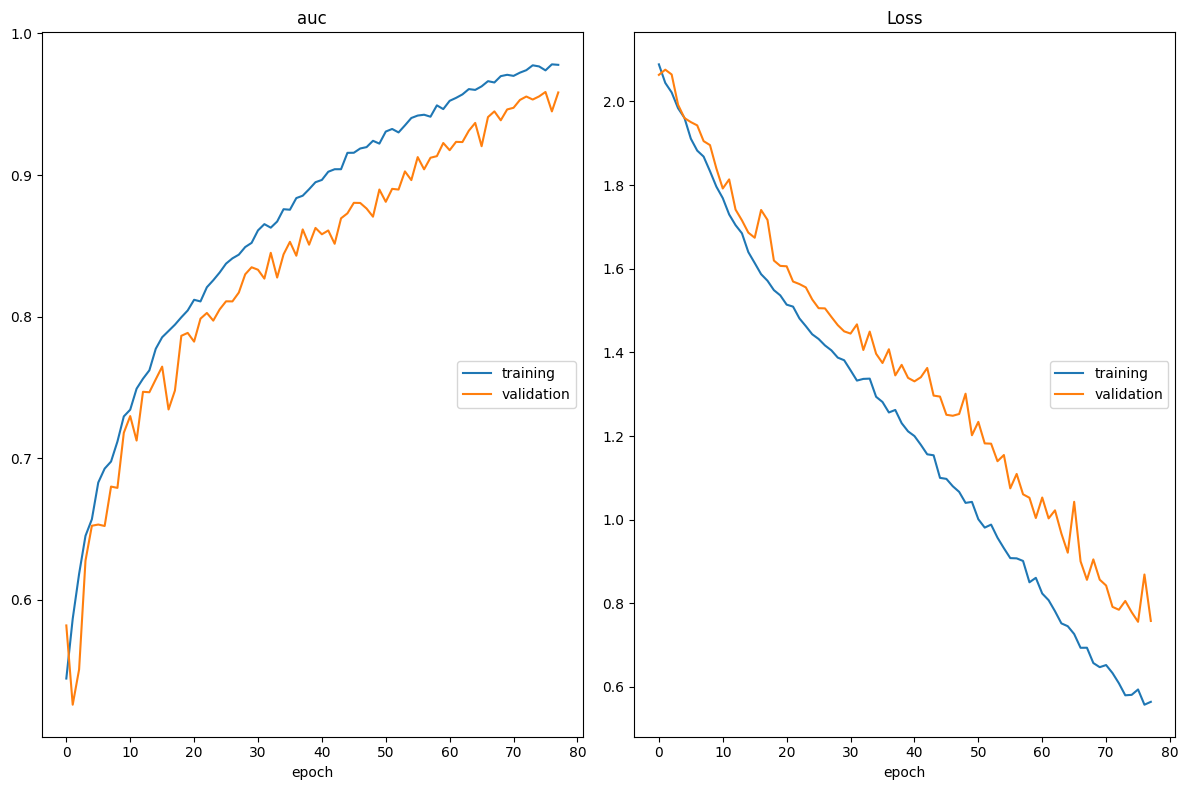

auc
	training         	 (min:    0.544, max:    0.978, cur:    0.978)
	validation       	 (min:    0.526, max:    0.959, cur:    0.958)
Loss
	training         	 (min:    0.558, max:    2.089, cur:    0.564)
	validation       	 (min:    0.756, max:    2.076, cur:    0.758)
6/6 ━━━━━━━━━━━━━━━━━━━━ 68s 10s/step - auc: 0.9814 - loss: 0.5331 - val_auc: 0.9583 - val_loss: 0.7578


In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_op.fit(train_X, train_label,
             batch_size = batch_size,
             epochs = epochs,
             verbose = 1,
             validation_data = (valid_X, valid_label),
             callbacks=[PlotLossesKeras(), early_stop])

In [ ]:
model_op.evaluate(test_X, test_y_one_hot, verbose = 1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 654ms/step - auc: 0.9543 - loss: 0.8070


[0.7816625237464905, 0.9563873410224915]

In [ ]:
model_op.save('model_optimo.h5')

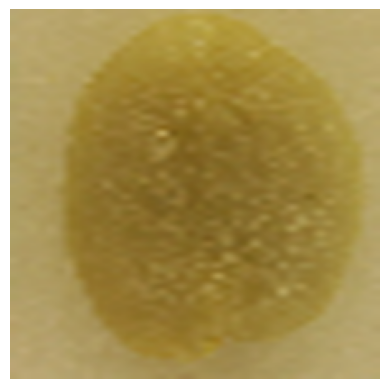

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
La predicción del modelo es: 6 La imagen corresponde a la clase: Negro


In [ ]:
# Preprocesamiento de imagen para hacer prediccion del modelo
image_test = plt.imread('/content/foto_test.JPG')
image_test = cv2.resize(image_test, (250, 250), interpolation = cv2.INTER_CUBIC)
image_test = image_test[70:140, 90:130]
image_test = cv2.resize(image_test, (224, 224), interpolation = cv2.INTER_CUBIC)

plt.imshow(image_test)
plt.axis("off")
plt.show()

image_test = np.array(image_test)
image_test = image_test.astype('float32')
image_test = np.expand_dims(image_test, axis=0)
image_test = image_test / 255.

# Realizar la predicción
predictions = model_op.predict(image_test, batch_size=None, verbose="auto", steps=None, callbacks=None)
predicted_class_label = le.inverse_transform([np.argmax(predictions)])[0]

# Imprimir la predicción
print(f'La predicción del modelo es: {np.argmax(predictions)} La imagen corresponde a la clase: {predicted_class_label.capitalize()}')

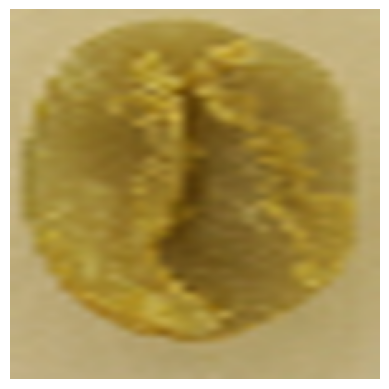

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
La predicción del modelo es: 6 La imagen corresponde a la clase: Negro


In [ ]:
# Preprocesamiento de imagen para hacer prediccion del modelo
image_test = plt.imread('/content/foto_test2.JPG')
image_test = cv2.resize(image_test, (250, 250), interpolation = cv2.INTER_CUBIC)
image_test = image_test[50:110, 120:150]
image_test = cv2.resize(image_test, (224, 224), interpolation = cv2.INTER_CUBIC)

plt.imshow(image_test)
plt.axis("off")
plt.show()

image_test = np.array(image_test)
image_test = image_test.astype('float32')
image_test = np.expand_dims(image_test, axis=0)
image_test = image_test / 255.

# Realizar la predicción
predictions = model_op.predict(image_test, batch_size=None, verbose="auto", steps=None, callbacks=None)
predicted_class_label = le.inverse_transform([np.argmax(predictions)])[0]

# Imprimir la predicción
print(f'La predicción del modelo es: {np.argmax(predictions)} La imagen corresponde a la clase: {predicted_class_label.capitalize()}')

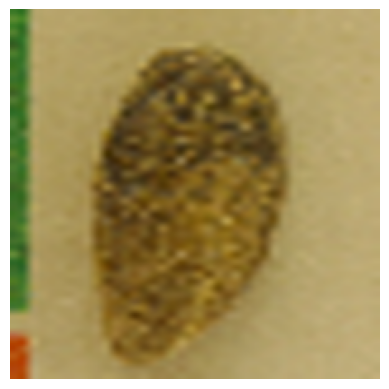

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
La predicción del modelo es: 2 La imagen corresponde a la clase: Buenos


In [ ]:
# Preprocesamiento de imagen para hacer prediccion del modelo
image_test = plt.imread('/content/foto_test3.JPG')
image_test = cv2.resize(image_test, (250, 250), interpolation = cv2.INTER_CUBIC)
image_test = image_test[70:125, 80:120]
image_test = cv2.resize(image_test, (224, 224), interpolation = cv2.INTER_CUBIC)

plt.imshow(image_test)
plt.axis("off")
plt.show()

image_test = np.array(image_test)
image_test = image_test.astype('float32')
image_test = np.expand_dims(image_test, axis=0)
image_test = image_test / 255.

# Realizar la predicción
predictions = model_op.predict(image_test, batch_size=None, verbose="auto", steps=None, callbacks=None)
predicted_class_label = le.inverse_transform([np.argmax(predictions)])[0]

# Imprimir la predicción
print(f'La predicción del modelo es: {np.argmax(predictions)} La imagen corresponde a la clase: {predicted_class_label.capitalize()}')

## Revision

In [ ]:
pred_y = model_op.predict(test_X)

predicted_classes = []
for predicted_s in pred_y:
    predicted_classes.append(predicted_s.tolist().index(max(predicted_s)))
predicted_classes = np.array(predicted_classes)

2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 630ms/step


In [ ]:
# verificacion de las predicciones correctas
correct = np.where(predicted_classes == test_Y)[0]
print('Se encontraron {} predicciones correctas'.format(len(correct)))

# verificacion de las predicciones incorrectas
incorrect = np.where(predicted_classes != test_Y)[0]
print('Se encontraron {} predicciones incorrectas'.format(len(incorrect)))

Se encontraron 35 predicciones correctas
Se encontraron 17 predicciones incorrectas


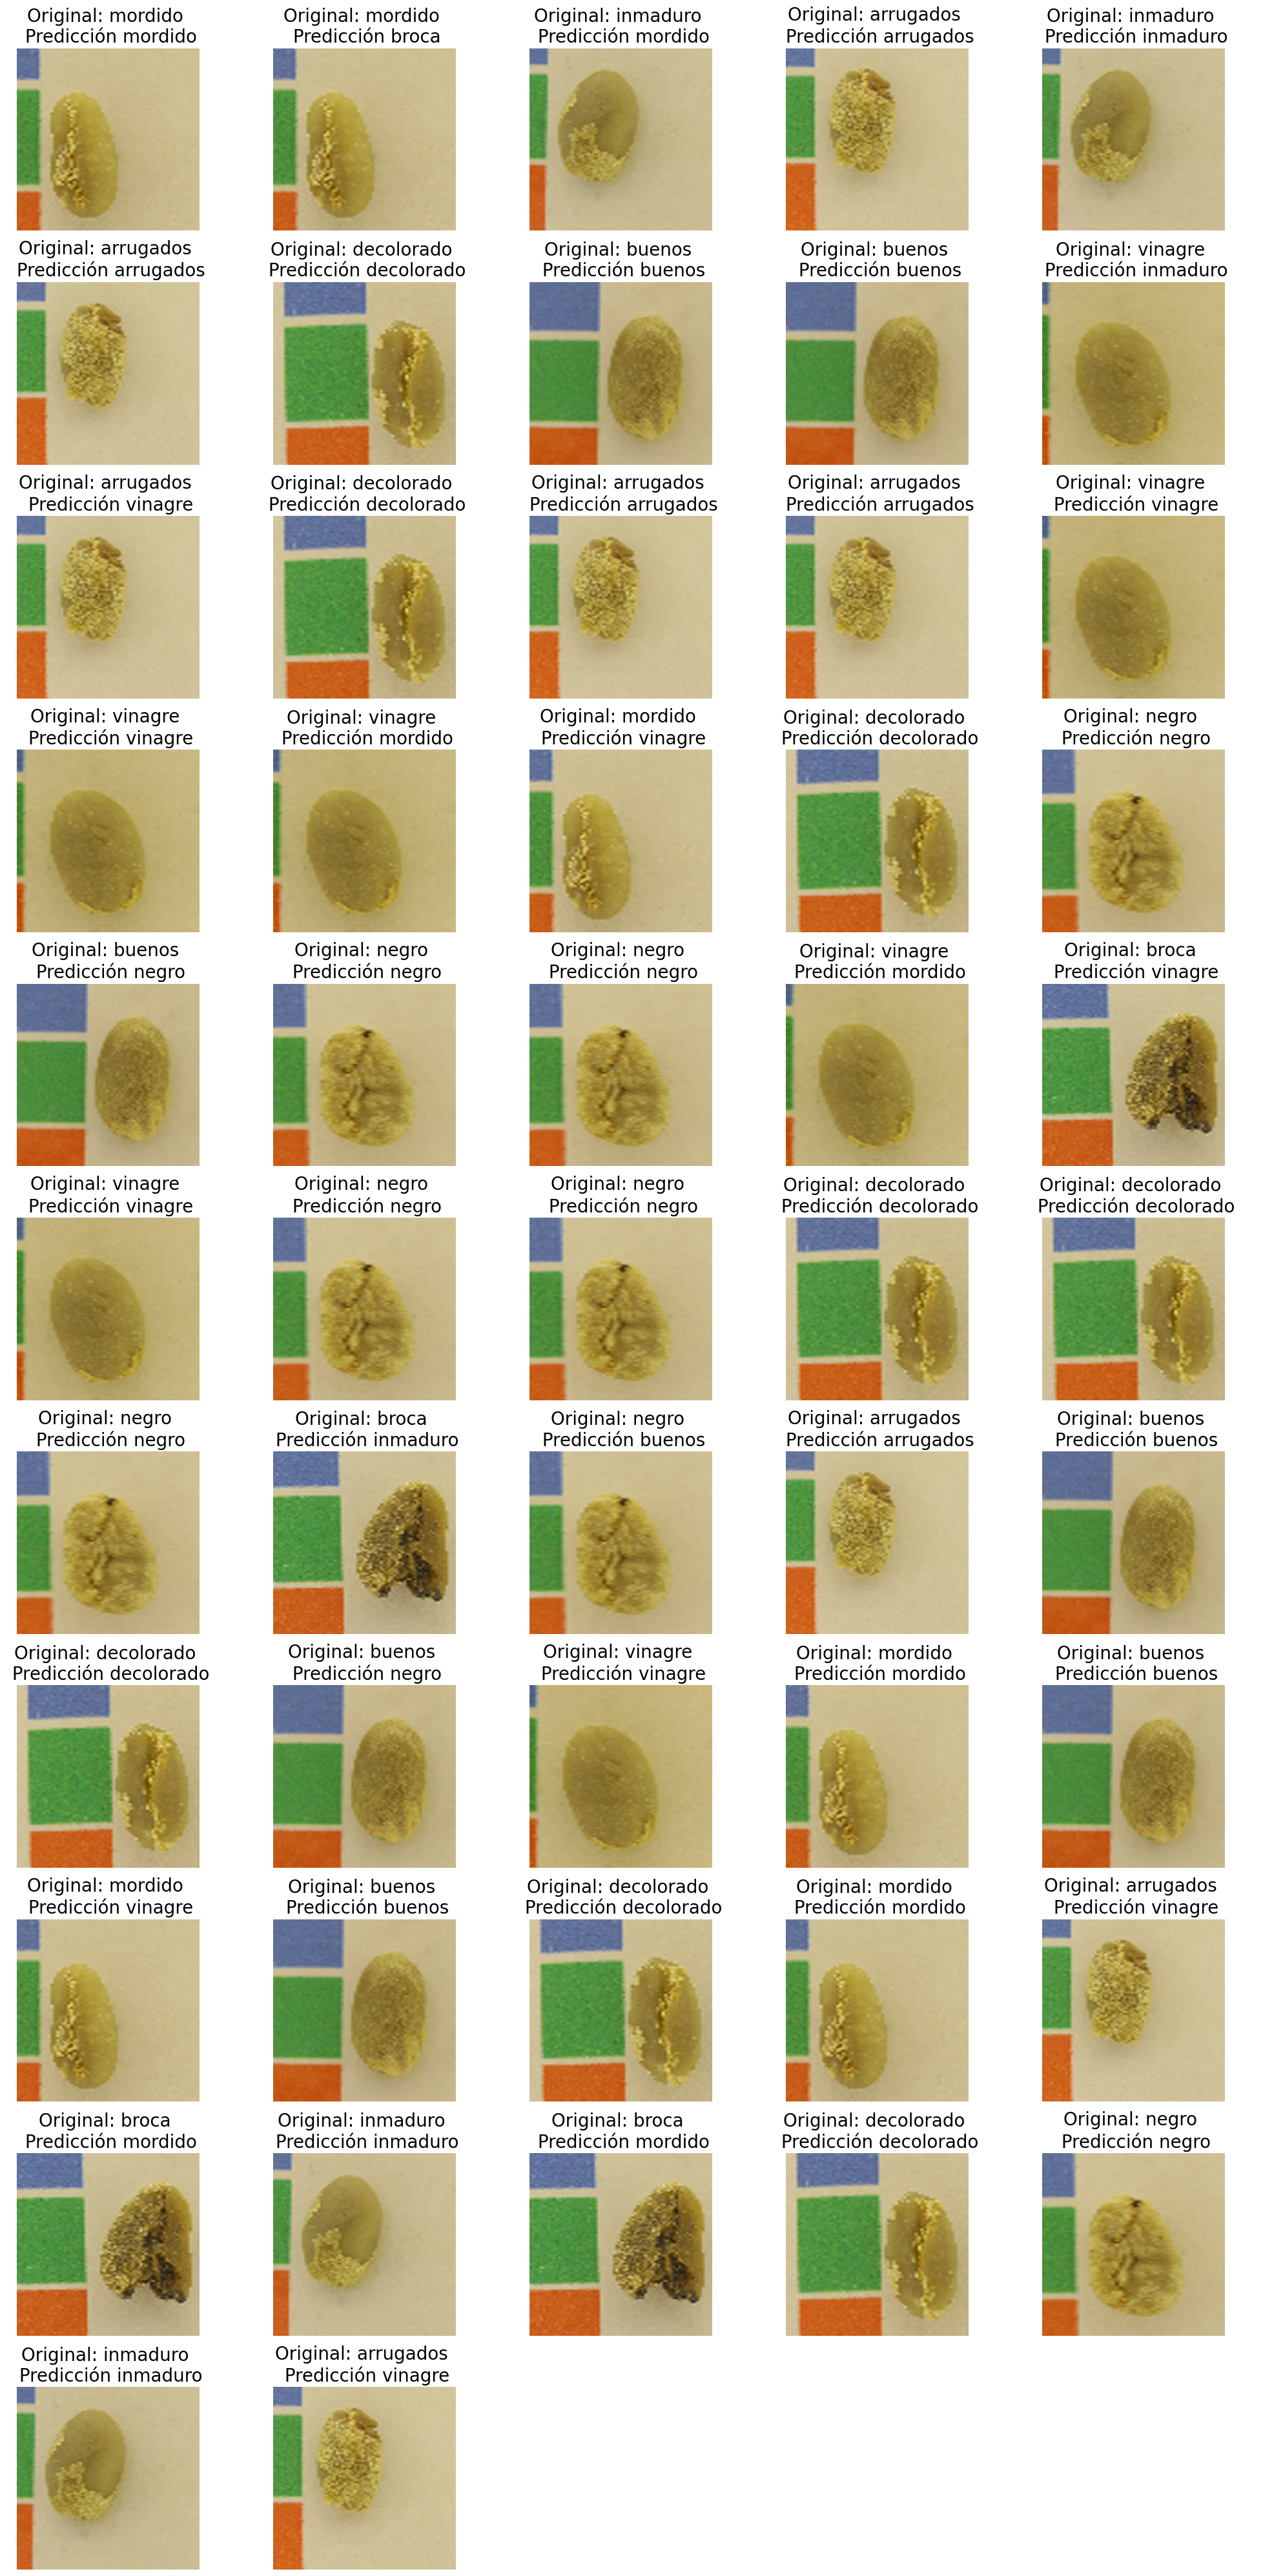

In [ ]:
visualize_graphs(test_X, test_Y, predicted_classes)

In [ ]:
target_names = ['class {}'.format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     class 0       1.00      0.62      0.77         8
     class 1       0.00      0.00      0.00         4
     class 2       0.83      0.71      0.77         7
     class 3       1.00      1.00      1.00         8
     class 4       0.60      0.75      0.67         4
     class 5       0.38      0.50      0.43         6
     class 6       0.78      0.88      0.82         8
     class 7       0.40      0.57      0.47         7

    accuracy                           0.67        52
   macro avg       0.62      0.63      0.62        52
weighted avg       0.68      0.67      0.67        52



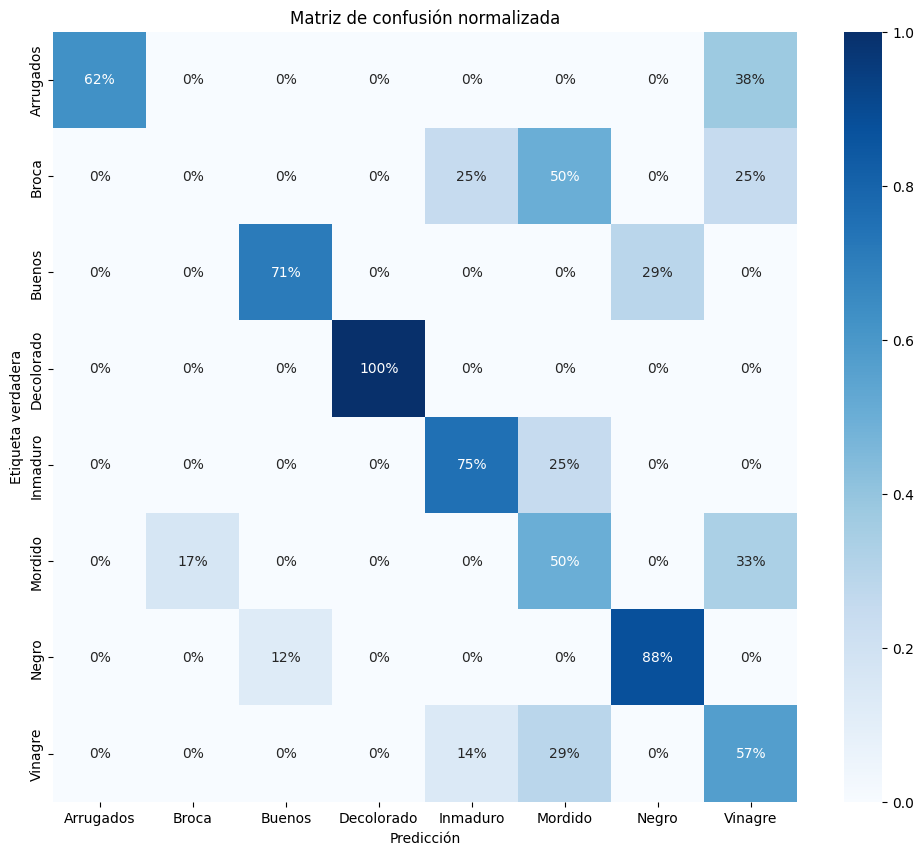

In [ ]:
cm = confusion_matrix(test_Y, predicted_classes, normalize='true')
class_labels = ['Arrugados', 'Broca', 'Buenos', 'Decolorado', 'Inmaduro', 'Mordido', 'Negro', 'Vinagre']

fig, axs = plt.subplots(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt='.0%', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')
plt.title('Matriz de confusión normalizada')
plt.show()

In [ ]:
print('Ok_')

Ok_
